In [7]:
%load_ext autoreload
%autoreload

import os
import numpy as np
import cv2
from osgeo import gdal
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/golden/coding/drone-tracking/code/functions')
import mapping_functions as kmap
from drone_movement import create_gt_segment_dicts, get_segment_drone_movement
from drone_movement import get_warp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
observation_name = 'observation046'

plot_save_folder = "/home/golden/Dropbox/drone-paper/figures/supplement"

kenya_drones_path = "/home/golden/kenya_drones"
maps_folder = os.path.join(kenya_drones_path,
                           "3D_mapping/small_maps"
                          )

tracks_file = os.path.join(kenya_drones_path, 
                       "processing/kenya-tracking/processed-videos/raw-footage",
                       observation_name, 
                       "localizations/tracks-complete.npy"
                      )

### Create segment dicts for calculating drone movement

In [9]:
frame_folders_root = os.path.join(kenya_drones_path, 
                                  "processing/kenya-tracking/raw-frames/raw-footage",
                                  observation_name
                                 )
pix4d_folder = os.path.join(maps_folder, observation_name)

pmatrix_file = pix4d_folder + '/1_initial/params/' + observation_name + '_pmatrix.txt' 
pmatrix_list = kmap.create_pmatrix_dicts(pmatrix_file)

# Load the saved flight logs that contain both drone sensor info and the video frame info
flight_logs_folder = os.path.join(pix4d_folder, 'drone-logs')
flight_logs = kmap.get_cleaned_flight_logs(flight_logs_folder,
                                          pmatrix_list
                                          )
segment_dicts = create_gt_segment_dicts(frame_folders_root, 
                                        flight_logs, 
                                        save=False)

83 gt images not used in final map.


In [10]:
len(segment_dicts[0]['segment_im_files'])

1144

In [5]:
segment_dicts[0].keys()

dict_keys(['segment_im_files', 'output_folder', 'segment_number', 'save'])

### Investigate individual segment

In [17]:
seg_ind = 1

# segment_transforms, num_inliers_list, pgts = get_segment_drone_movement(segment_dicts[seg_ind])

In [11]:
import glob
drone_movement_folder = os.path.join(frame_folders_root, 
                                         "drone_movement_test_new_correct_gt_inds" 
                                        )
drone_movements_files = os.path.join(drone_movement_folder,
                                       "drone_movement_segment_*.npy"
                                      )
segment_movement_files = sorted(glob.glob(drone_movements_files))
segment_movements = [np.load(file) for file in segment_movement_files]

In [12]:
len(segment_movement_files)

341

In [18]:
segment_transforms = segment_movements[seg_ind]

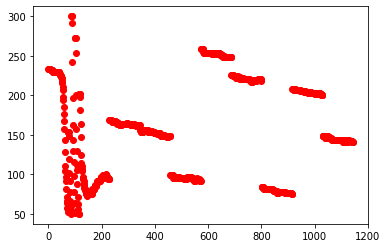

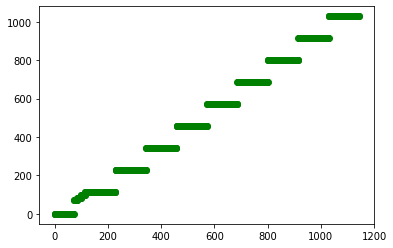

In [19]:
segment_transforms = np.array(segment_transforms)
drone_translation = np.sqrt(segment_transforms[:, 0, 2] ** 2 
                            + segment_transforms[:, 1, 2] ** 2)
plt.plot(drone_translation, 'bo')
# ax2 = plt.gca().twinx()
plt.figure()
plt.plot(num_inliers_list, 'ro')
# ax3 = plt.gca().twinx()
plt.figure()
plt.plot(pgts, 'go')

### Show resulting final segment warp (last frame of this segment (first frame of next segment) to first of this segment)

Text(0.5, 1.0, 'No Correction')

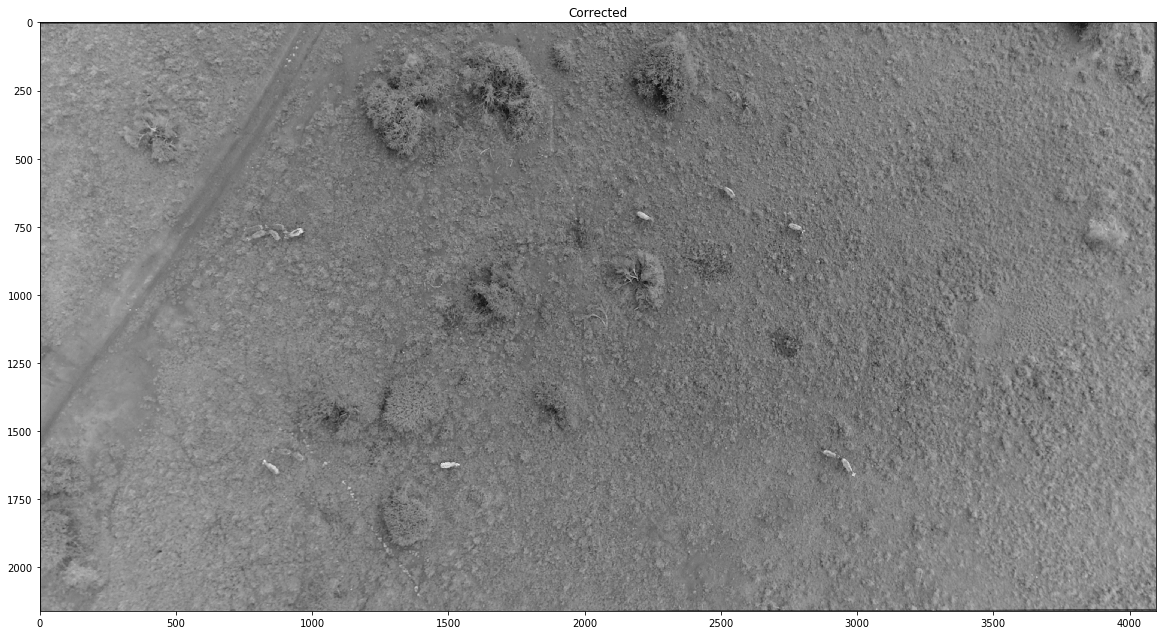

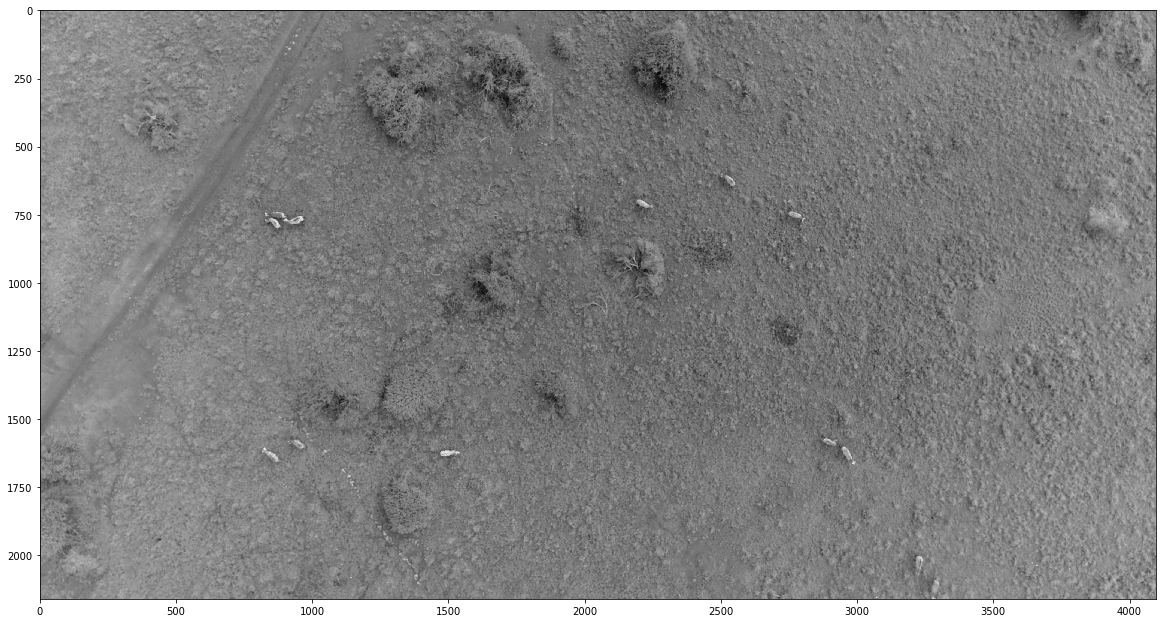

In [20]:
seg_im_files = segment_dicts[seg_ind]['segment_im_files']

seg_ind0 = 0
seg_ind1 = -1

frame0_raw = cv2.imread(seg_im_files[seg_ind0])
frame0_gray = cv2.cvtColor(frame0_raw, cv2.COLOR_BGR2GRAY)

frame1_raw = cv2.imread(seg_im_files[seg_ind1])
frame1_gray = cv2.cvtColor(frame1_raw, cv2.COLOR_BGR2GRAY)

warp = segment_transforms[seg_ind1]

warped_image = cv2.warpAffine(frame1_gray, M=warp[:2], 
                              dsize=(frame0_raw.shape[1], frame0_raw.shape[0]))

plt.figure(figsize=(20,20))
plt.imshow(frame0_gray, cmap='gray', )
plt.imshow(frame1_gray, alpha=.5, cmap='gray')
plt.title("No Correction")

plt.figure(figsize=(20,20))
plt.imshow(frame0_gray, cmap='gray', )
plt.imshow(warped_image, alpha=.5, cmap='gray')
plt.title("Corrected")

plt.figure(figsize=(20,20))
plt.imshow(frame0_gray, cmap='gray', )
plt.figure(figsize=(20,20))
plt.imshow(frame1_gray, alpha=1.0, cmap='gray')
plt.title("No Correction")

### Get segment utm projection error

In [155]:
load_map = True

tracks_file = os.path.join(kenya_drones_path, 
                           "processing/kenya-tracking/processed-videos/raw-footage",
                           observation_name, 
                           "localizations/tracks-complete.npy"
                          )
tracks = np.load(tracks_file, allow_pickle=True)
gt_obs_inds, _ = kmap.get_groundtruth_obs_indexes(flight_logs, 
                                                     frame_folders_root, 
                                                     for_test=False
                                                    )


if load_map:
    offset_file = os.path.join(pix4d_folder, "1_initial/params",
                           f"{observation_name}_offset.xyz"
                          )
    offset = kmap.load_map_offset(offset_file)

    geotif_dsm_file =  os.path.join(pix4d_folder, 
                                    "3_dsm_ortho/1_dsm",
                                    f"{observation_name}_dsm.tif"
                                   )
    dsm_gtif = gdal.Open(geotif_dsm_file)
    # Get information for converting between utm and raster coordinates
    dsm_transform = dsm_gtif.GetGeoTransform()
    x_origin = dsm_transform[0]
    y_origin = dsm_transform[3]
    pixel_width = dsm_transform[1]
    pixel_height = dsm_transform[5]


    geotif_dtm_file =  os.path.join(pix4d_folder, 
                                "3_dsm_ortho/extras/dtm", 
                                f"{observation_name}_dtm.tif"
                               )
    dtm_gtif = gdal.Open(geotif_dtm_file)
    dtm = dtm_gtif.GetRasterBand(1).ReadAsArray()
    dtm = kmap.fill_with_min(dtm)
    elevation_r = cv2.resize(dtm, (dsm_gtif.RasterXSize, dsm_gtif.RasterYSize), 
                         interpolation=cv2.INTER_CUBIC
                        )
    
    demo_frame_name = list(flight_logs[0].loc[flight_logs[0]['used_in_map'], 'image_name'])[0]
    demo_frame_file = os.path.join(frame_folders_root, 
                                   '_'.join(demo_frame_name.split('_')[:-1]), # was 5 from drone_movement_test 
                                   demo_frame_name)
    demo_frame = plt.imread(demo_frame_file)

segment_movements = [np.eye(3) for _ in range(seg_ind+1)]
segment_movements[seg_ind] = segment_transforms

gt_obs_ind = gt_obs_inds[seg_ind+1]
correct_threshold = 0.2
max_guesses = 50
mu_est = 80
segment_errors = kmap.calculate_total_segment_error(tracks, gt_obs_ind, 
                                           seg_ind, pmatrix_list, 
                                           segment_movements,
                                           mu_est, offset, 
                                           elevation_r, max_guesses,
                                           correct_threshold, 
                                           pixel_width, pixel_height,
                                           x_origin, y_origin, 
                                           demo_frame.shape,
                                           object_height=1
                                          )

distances = np.linalg.norm(segment_errors, axis=1)
print(distances)
mean_distances = np.nanmean(distances)
print(f"mean error {mean_distances}m",
      f"max error: {np.nanmax(distances)}m",
      f"min error: {np.nanmin(distances)}m")

APR08_2018_A_DJI_0008_08226.jpg not found
trying APR08_2018_A_DJI_0008_08224.jpg
gt not found. using APR08_2018_A_DJI_0008_08224.jpg for APR08_2018_A_DJI_0008_08226.jpg.
[0.32230602 0.27953659 2.56987713 1.40162378 0.75313318 0.49357384
 0.25727373 0.44146586 0.12863687 3.56824022 0.46380681 0.64887634
 1.43820388 0.06779758 0.4507392  0.50462537 0.62506281 1.516     ]
mean error 0.8850432894761251m max error: 3.568240216122035m min error: 0.06779758108965346m


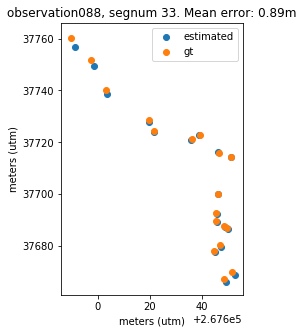

In [156]:
obs_ind = gt_obs_inds[seg_ind+1]

save = False

# To get correct mu value
_, new_mu = kmap.calculate_obs_ind_utms_in_segment(tracks, obs_ind, seg_ind, -1,
                                                    pmatrix_list, segment_movements,
                                                    mu_est, offset, elevation_r, max_guesses,
                                                    correct_threshold, pixel_width, pixel_height,
                                                    x_origin, y_origin, demo_frame.shape, 
                                                      object_height=1
                                                   )
utm_last, _ = kmap.calculate_obs_ind_utms_in_segment(tracks, obs_ind, seg_ind, -1,
                                                    pmatrix_list, segment_movements,
                                                    new_mu, offset, elevation_r, max_guesses,
                                                    correct_threshold, pixel_width, pixel_height,
                                                    x_origin, y_origin, demo_frame.shape, 
                                                      object_height=1
                                                   )
utm_first, _ = kmap.calculate_obs_ind_utms_in_segment(tracks, obs_ind, seg_ind+1, 0,
                                                    pmatrix_list, segment_movements,
                                                    new_mu, offset, elevation_r, max_guesses,
                                                    correct_threshold, pixel_width, pixel_height,
                                                    x_origin, y_origin, demo_frame.shape, 
                                                      object_height=1
                                                   )

plt.figure(figsize=(5,5))
plt.scatter(utm_last[:, 0], utm_last[:, 1], label="estimated")
plt.scatter(utm_first[:, 0], utm_first[:, 1], label="gt")
plt.gca().set_aspect('equal')
plt.xlabel('meters (utm)')
plt.ylabel('meters (utm)')
plt.legend()
diff = utm_last - utm_first
plt.title(f"{observation_name}, segnum {seg_ind}. Mean error: {mean_distances:0.2f}m")

name = f"{observation_name}-segnum-{seg_ind}-mean_error-{mean_distances:0.2f}m"
if save:
    plt.savefig(os.path.join(plot_save_folder, name+".png"), dpi=300)

### Calcluate and visualize warp from one frame to another (no pseudo gts)

299 inliers


Text(0.5, 1.0, 'Corrected')

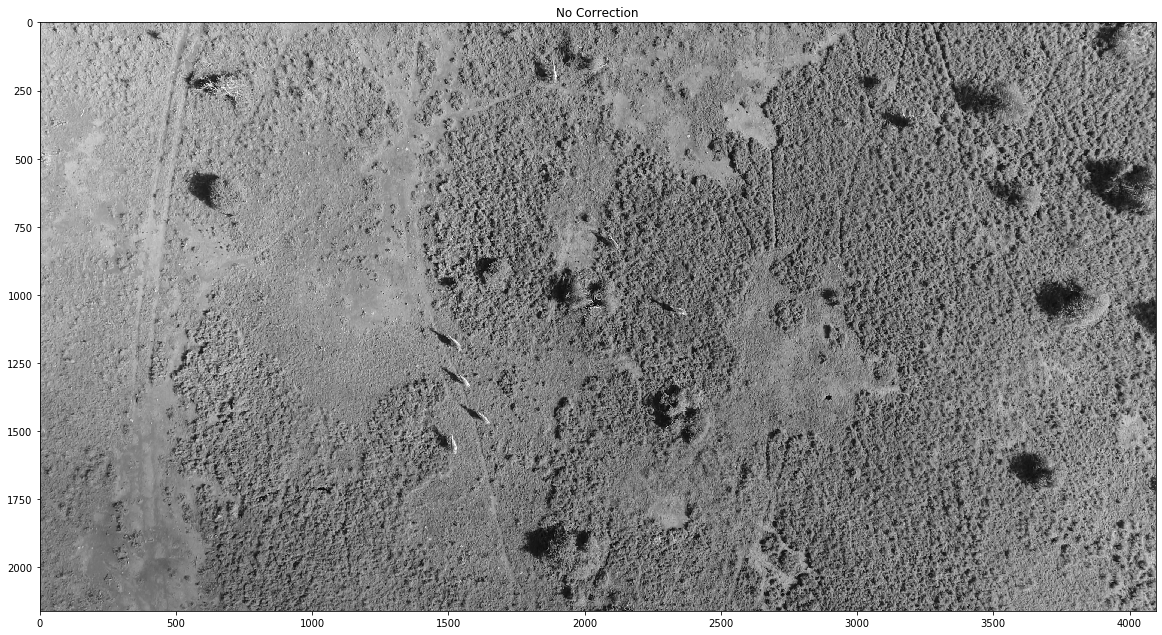

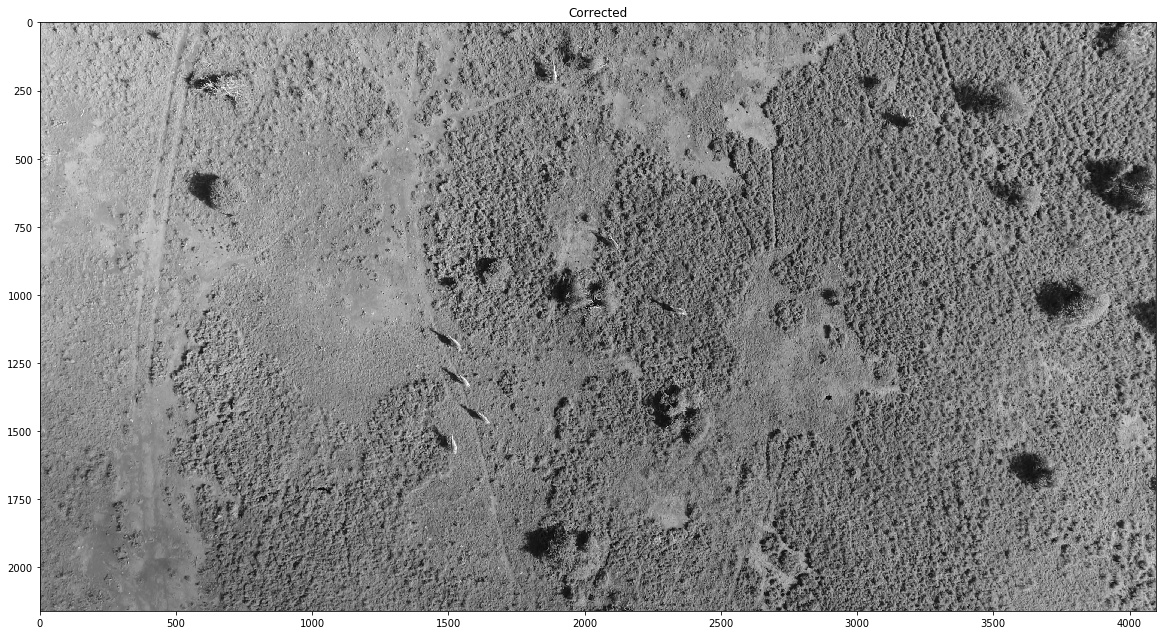

In [19]:
seg_im_files = segment_dicts[seg_ind]['segment_im_files']

frame0_raw = cv2.imread(seg_im_files[19])
frame0_gray = cv2.cvtColor(frame0_raw, cv2.COLOR_BGR2GRAY)

frame1_raw = cv2.imread(seg_im_files[21])
frame1_gray = cv2.cvtColor(frame1_raw, cv2.COLOR_BGR2GRAY)

warp, num_inliers = get_warp(frame0_gray, frame1_gray, plot_inliers=False)

print(f"{num_inliers} inliers")

warped_image = cv2.warpAffine(frame1_gray, M=warp[:2], 
                              dsize=(frame0_raw.shape[1], frame0_raw.shape[0]))

plt.figure(figsize=(20,20))
plt.imshow(frame0_gray, cmap='gray', )
plt.imshow(frame1_gray, alpha=.5, cmap='gray')
plt.title("No Correction")

plt.figure(figsize=(20,20))
plt.imshow(frame0_gray, cmap='gray', )
plt.imshow(warped_image, alpha=.5, cmap='gray')
plt.title("Corrected")
# plt.figure(figsize=(20,20))
# plt.imshow(frame0_gray, cmap='gray')
# plt.figure(figsize=(20,20))
# plt.imshow(frame1_gray, alpha=1, cmap='gray')

In [92]:
glob_string = f"/home/golden/kenya_drones/3D_mapping/small_maps/{observation_name}/map-images/*.jpg"
gt_image_files = sorted(glob.glob(glob_string))

NameError: name 'glob' is not defined